In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr, linregress

In [52]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
# proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038']

da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='kde_af')
da.load_results_da()

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


5041.1127765100155 3016.77983666189 5502.113555955339
0.0 25.216 24.93199999999999


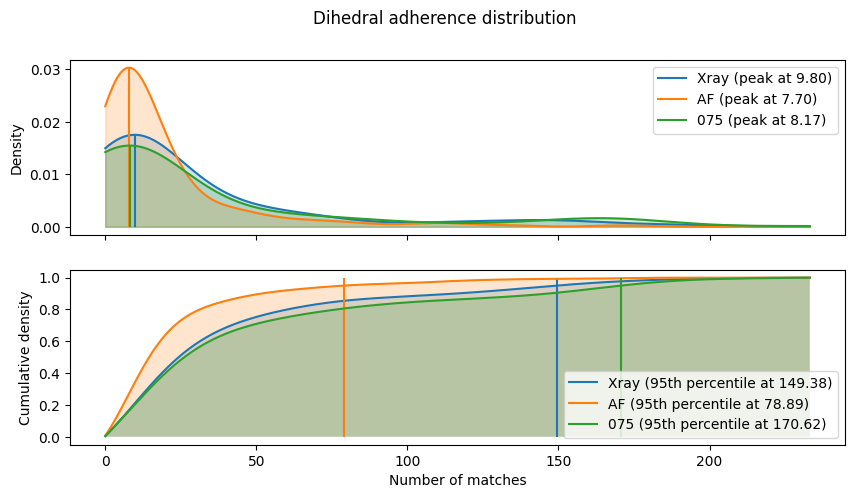

In [150]:
from scipy.stats import gaussian_kde

xray_phi_psi = da.xray_phi_psi.dropna().copy()
af_phi_psi = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == da.alphafold_id].dropna().copy()
results = da.grouped_preds.set_index('protein_id')
xray_phi_psi['rmsd'] = 0
af_phi_psi['rmsd'] = results.loc[da.alphafold_id].RMS_CA

other_id = da.protein_ids[0]
other_phi_psi = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == other_id].dropna().copy()
other_phi_psi['rmsd'] = results.loc[other_id].RMS_CA

print(xray_phi_psi.da.sum(), af_phi_psi.da.sum(), other_phi_psi.da.sum())
print(xray_phi_psi.rmsd.mean(), af_phi_psi.rmsd.mean(), other_phi_psi.rmsd.mean())

df = pd.concat([
    xray_phi_psi, 
    af_phi_psi.drop('da_na', axis=1),
    other_phi_psi.drop('da_na', axis=1)
])

def get_probs(x, da):
    kde = gaussian_kde(da)
    p = kde(x)
    c = np.cumsum(p) / np.sum(p)
    peak = x[np.argmax(p)]
    return p, c, peak

fig, axes = plt.subplots(2, sharex=True, figsize=(10, 5))
x = np.linspace(0, df.da.max(), 1000)

def plot(df, label, color):
    p, c, peak = get_probs(x, df.da)
    axes[0].plot(x, p, color=color, label=f'{label} (peak at {peak:.2f})')
    axes[0].fill_between(x, 0, p, alpha=0.2, color=color)
    axes[0].vlines(peak, 0, p.max(), color=color)
    perc = x[np.argmax(c > 0.95)]
    axes[1].plot(x, c, color=color, label=f'{label} (95th percentile at {perc:.2f})')
    axes[1].vlines(perc, 0, 1, color=color)
    axes[1].fill_between(x, 0, c, alpha=0.2)

colors = sns.color_palette("tab10")
plot(xray_phi_psi, 'Xray', colors[0])
plot(af_phi_psi, 'AF', colors[1])
plot(other_phi_psi, other_id[7:10], colors[2])
axes[0].legend()
axes[0].set_ylabel('Density')
axes[1].legend(loc='lower right')
axes[1].set_xlabel('Number of matches')
axes[1].set_ylabel('Cumulative density')
# axes[0].set_xlim(0, 5000)
# axes[1].set_xlim(0, 5000)
fig.suptitle('Dihedral adherence distribution')
plt.show()

Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found
Slope: -0.5513389837029513, Intercept: 56.92555404170489 R-squared: 0.7066809773030521


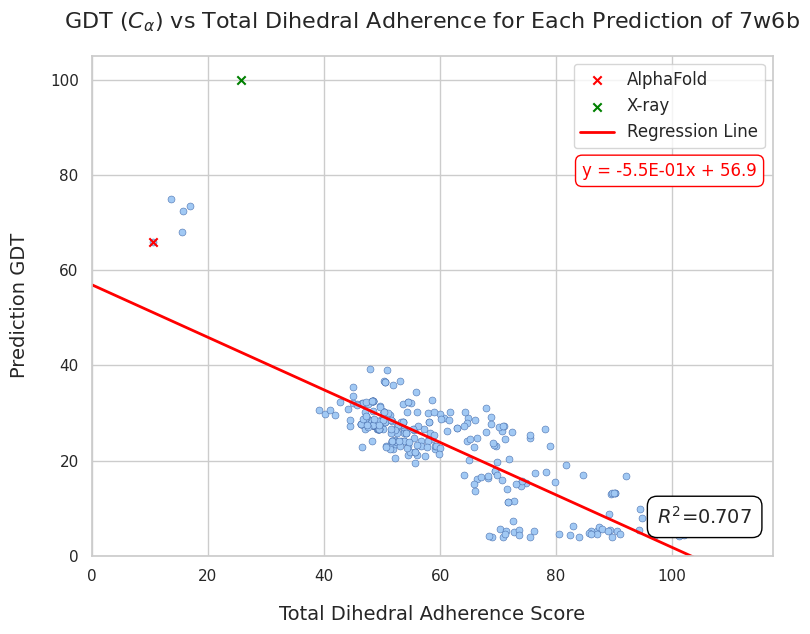

In [12]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']

da = DihedralAdherence(proteins[2], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
da.load_results_da()
da.filter_nas(0.8)
da.plot_da_vs_gdt_simple()

In [35]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']
t0 = 64.0
n = 4
thresholds = np.array([t0 * (i+1) for i in range(n)])
scores = []
gdts = []
pred_ids = []
da = DihedralAdherence(proteins[2], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                    mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
da.load_results_da()
da.filter_nas(0.8)
for id in da.protein_ids:
    pred = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
    if pred.shape[0] == 0:
        continue
    gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
    if len(gdt) == 0:
        continue
    gdt = gdt[0]
    score = [(pred.da < thresholds[0]).sum() / pred.shape[0]]
    for i in range(1, n):
        # score.append(((pred.da > thresholds[i-1]) & (pred.da < thresholds[i])).sum() / pred.shape[0])
        score.append(((pred.da < thresholds[i])).sum() / pred.shape[0])
    scores.append(np.mean(score))
    gdts.append(gdt)
    pred_ids.append(id)
das = pd.DataFrame({'protein_id': pred_ids, 'gdt': gdts, 'score': scores})

Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


0.666244003711376 PearsonRResult(statistic=0.8162377127475664, pvalue=6.774123686349922e-75)
Slope: 170.6352913263256, Intercept: -123.53723034793248


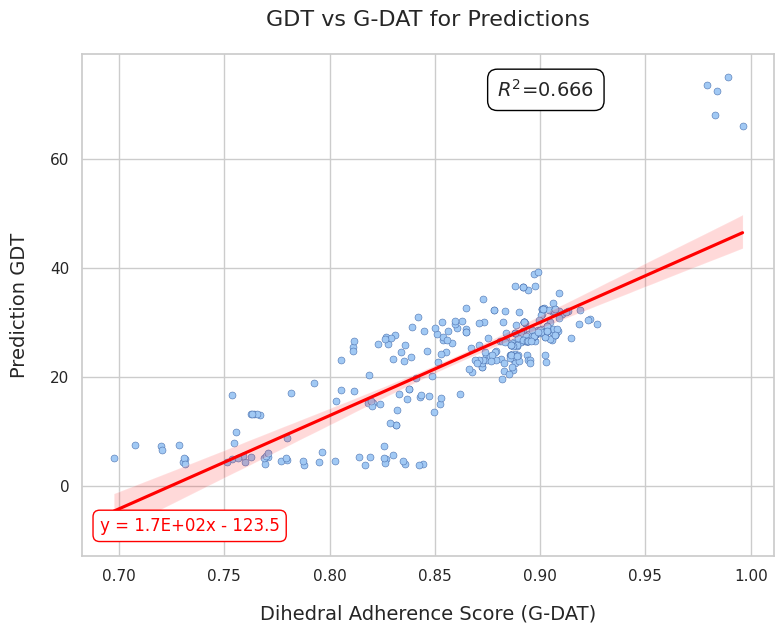

In [36]:
sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 6.5))
das = das.dropna(subset=['score', 'gdt']).reset_index(drop=True)
# df = df[df.GDT_TS < 20]
regr = linregress(das.score, das.gdt)
corr = pearsonr(das['score'], das['gdt'])
print(regr.rvalue**2, corr)
print(f'Slope: {regr.slope}, Intercept: {regr.intercept}')
sns.scatterplot(data=das, x='score', y='gdt', ax=ax, marker='o', s=25, edgecolor='b', legend=True)
sns.regplot(data=das.reset_index(drop=True), x='score', y='gdt', ax=ax, scatter=False, color='red')

ax.set_xlabel('Dihedral Adherence Score (G-DAT)', fontsize=14, labelpad=15)
ax.set_ylabel('Prediction GDT', fontsize=14, labelpad=15)
ax.set_title(r'GDT vs G-DAT for Predictions', fontsize=16, pad=20)
ax.text(0.6, 0.95, r'$R^2$='+f'{regr.rvalue**2:.3f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
if regr.intercept > 0:
    s = f'y = {regr.slope:.1E}x + {regr.intercept:.1f}'
else:
    s = f'y = {regr.slope:.1E}x - {-regr.intercept:.1f}'
ax.text(.025,.05, s, transform=ax.transAxes, fontsize=12, color='red',
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))
# plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
sns.reset_defaults()

# Combined

In [ ]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'

proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2']
results = []
maxt = [32,16,8]
for i,nthresh in enumerate([4,5,6]):
# for nthresh in [2,3]:
    for thresh1 in np.linspace(1, maxt[i], maxt[i]).round(2):
    # for thresh1 in np.linspace(1, 64, 64).round(2):
        thresholds = np.array([thresh1 * 2**i for i in range(nthresh)])
        scores = []
        gdts = []
        protein_ids = []
        for protein in proteins:
            da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                                mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
            da.load_results_da()
            da.filter_nas(0.8)
            pbar = tqdm(da.protein_ids)
            pbar.set_description(f'Nthresh {nthresh} Protein {protein} Initial Threshold {thresh1}')

            for id in pbar:
                pred = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
                if pred.shape[0] == 0:
                    continue
                gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
                if len(gdt) == 0:
                    continue
                gdt = gdt[0]
                score = np.mean([(pred.da < thresh).sum() / pred.shape[0] for thresh in thresholds])
                scores.append(score)
                gdts.append(gdt)
                protein_ids.append(protein)
                pred_ids.append(id)
            
        model = stats.linregress(gdts, scores)
        results.append((nthresh, thresh1, model.slope, model.intercept, model.rvalue**2, model.pvalue))
        results_df = pd.DataFrame(results, columns=['nthresh', 'initial_threshold', 'slope', 'intercept', 'rsquared', 'pvalue'])
        results_df.to_csv('results_threshold_combined2.csv', index=False)

In [225]:
df = pd.read_csv('results_threshold_combined2.csv')
df.sort_values('rsquared', ascending=False).head(5)

,nthresh,initial_threshold,slope,intercept,rsquared,pvalue
103,3,40.0,0.005856,0.606763,0.529425,0.0
105,3,42.0,0.005575,0.628165,0.529379,0.0
98,3,35.0,0.006534,0.555578,0.529338,0.0
104,3,41.0,0.005720,0.617352,0.529245,0.0
101,3,38.0,0.006141,0.585450,0.529080,0.0


In [15]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']
t0 = 40.0
n = 3
thresholds = np.array([t0 * 2**i for i in range(n)])
scores = []
gdts = []
pred_ids = []
da = DihedralAdherence('T1091', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                    mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
da.load_results_da()
da.filter_nas(0.8)
for id in da.protein_ids:
    pred = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
    if pred.shape[0] == 0:
        continue
    gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
    if len(gdt) == 0:
        continue
    gdt = gdt[0]
    score = np.mean([(pred.da < thresh).sum() / pred.shape[0] for thresh in thresholds])
    scores.append(score)
    gdts.append(gdt)
    pred_ids.append(id)
das = pd.DataFrame({'protein_id': pred_ids, 'gdt': gdts, 'score': scores})

Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


0.6944474221233401 PearsonRResult(statistic=0.8333351199387559, pvalue=9.024793905632e-81)
Slope: 93.33834341036106, Intercept: -43.61745160908512


/tmp/ipykernel_254593/2736912416.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


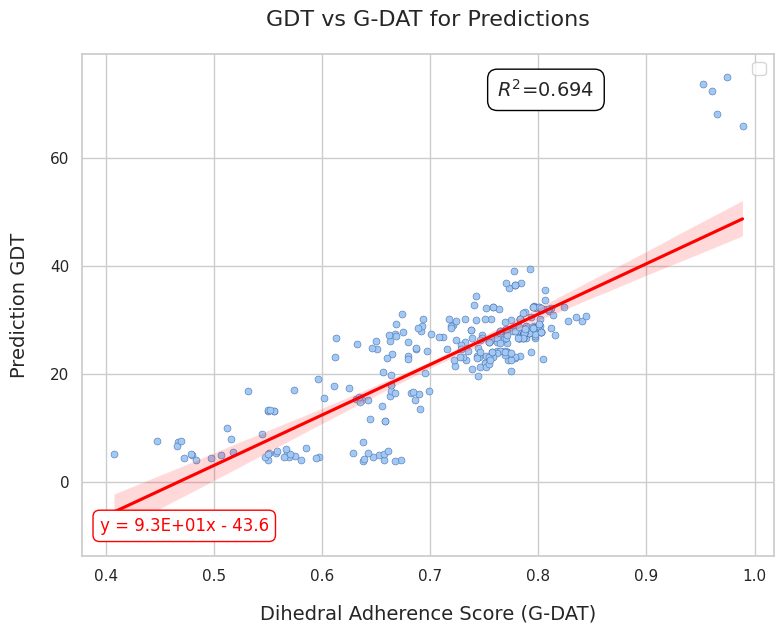

In [16]:
sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 6.5))
das = das.dropna(subset=['score', 'gdt']).reset_index(drop=True)
# df = df[df.GDT_TS < 20]
regr = linregress(das.score, das.gdt)
corr = pearsonr(das['score'], das['gdt'])
print(regr.rvalue**2, corr)
print(f'Slope: {regr.slope}, Intercept: {regr.intercept}')
sns.scatterplot(data=das, x='score', y='gdt', ax=ax, marker='o', s=25, edgecolor='b', legend=True)
sns.regplot(data=das.reset_index(drop=True), x='score', y='gdt', ax=ax, scatter=False, color='red')

ax.set_xlabel('Dihedral Adherence Score (G-DAT)', fontsize=14, labelpad=15)
ax.set_ylabel('Prediction GDT', fontsize=14, labelpad=15)
ax.set_title(r'GDT vs G-DAT for Predictions', fontsize=16, pad=20)
ax.text(0.6, 0.95, r'$R^2$='+f'{regr.rvalue**2:.3f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
if regr.intercept > 0:
    s = f'y = {regr.slope:.1E}x + {regr.intercept:.1f}'
else:
    s = f'y = {regr.slope:.1E}x - {-regr.intercept:.1f}'
ax.text(.025,.05, s, transform=ax.transAxes, fontsize=12, color='red',
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
sns.reset_defaults()

In [ ]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']
t0 = 40.0
n = 3
thresholds = np.array([t0 * 2**i for i in range(n)])
scores = []
gdts = []
protein_ids = []
pred_ids = []
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                        mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
    da.load_results_da()
    da.filter_nas(0.8)
    pbar = tqdm(da.protein_ids)
    pbar.set_description(f'Protein {protein}')
    for id in pbar:
        pred = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
        if pred.shape[0] == 0:
            continue
        gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
        if len(gdt) == 0:
            continue
        gdt = gdt[0]
        score = np.mean([(pred.da < thresh).sum() / pred.shape[0] for thresh in thresholds])
        scores.append(score)
        gdts.append(gdt)
        protein_ids.append(protein)
        pred_ids.append(id)
das = pd.DataFrame({'protein': protein_ids, 'gdt': gdts, 'score': scores, 'pred_id': pred_ids})

0.44887130195678454 PearsonRResult(statistic=0.6699785832075417, pvalue=0.0)
Slope: 99.78096675443987, Intercept: -41.25580993684637


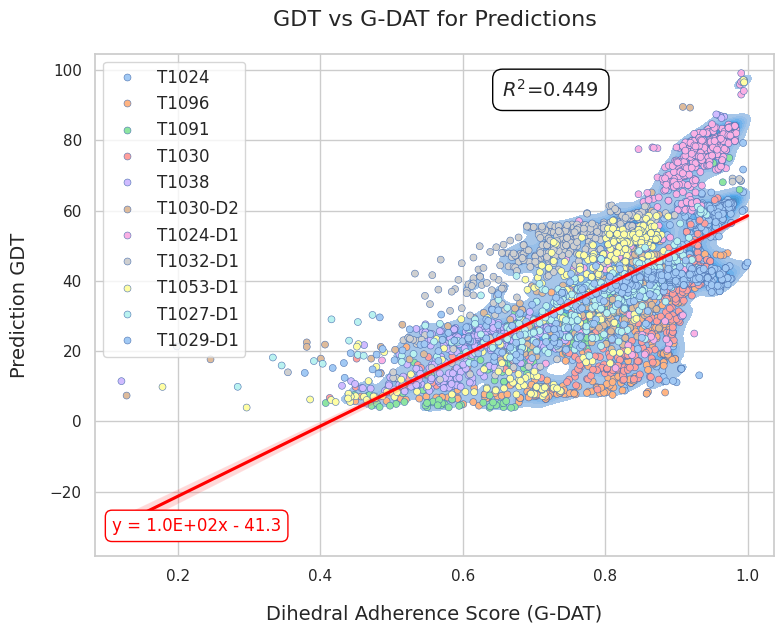

In [251]:
sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 6.5))
das = das.dropna(subset=['score', 'gdt']).reset_index(drop=True)
# df = df[df.GDT_TS < 20]
regr = linregress(das.score, das.gdt)
corr = pearsonr(das['score'], das['gdt'])
print(regr.rvalue**2, corr)
print(f'Slope: {regr.slope}, Intercept: {regr.intercept}')
sns.kdeplot(data=das, x='score', y='gdt', ax=ax, fill=True, bw_method=0.1)
sns.scatterplot(data=das, x='score', y='gdt', ax=ax, marker='o', s=25, edgecolor='b', legend=True, hue='protein', palette='pastel')
sns.regplot(data=das.reset_index(drop=True), x='score', y='gdt', ax=ax, scatter=False, color='red')

ax.set_xlabel('Dihedral Adherence Score (G-DAT)', fontsize=14, labelpad=15)
ax.set_ylabel('Prediction GDT', fontsize=14, labelpad=15)
ax.set_title(r'GDT vs G-DAT for Predictions', fontsize=16, pad=20)
ax.text(0.6, 0.95, r'$R^2$='+f'{regr.rvalue**2:.3f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
if regr.intercept > 0:
    s = f'y = {regr.slope:.1E}x + {regr.intercept:.1f}'
else:
    s = f'y = {regr.slope:.1E}x - {-regr.intercept:.1f}'
ax.text(.025,.05, s, transform=ax.transAxes, fontsize=12, color='red',
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
sns.reset_defaults()

In [254]:
thresholds

array([ 40.,  80., 160.])

In [253]:
das

,protein,gdt,score,pred_id
0,T1024,59.08,0.965070,T1024TS379_4
1,T1024,60.49,0.957998,T1024TS362_1
2,T1024,34.34,0.870420,T1024TS004_5
3,T1024,62.08,0.976765,T1024TS015_2
4,T1024,37.85,0.961573,T1024TS070_5
...,...,...,...,...
4285,T1029-D1,40.00,0.899160,T1029TS125_1-D1
4286,T1029-D1,34.20,0.773109,T1029TS138_3-D1
4287,T1029-D1,27.40,0.649860,T1029TS437_2-D1
4288,T1029-D1,19.00,0.675070,T1029TS196_1-D1


In [257]:
results = []
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']
total_samples = 0
for protein in proteins:
    df = das[das.protein == protein]
    n_preds = df.shape[0]
    total_samples += n_preds
    regr = linregress(df.score, df.gdt)
    rsquared = regr.rvalue**2
    corr = pearsonr(df.score, df.gdt)[0]
    results.append((protein, rsquared, corr, n_preds))
results = pd.DataFrame(results, columns=['protein', 'rsquared', 'pearsonr', 'n_preds'])
results.loc[len(results)] = ['Mean', results.rsquared.mean(), results.pearsonr.mean(), results.n_preds.mean()]
print(total_samples)
results.to_markdown('thisresult.md',index=False)

4290


# Fit linregr from percents to GDT

In [116]:
x = np.random.randn(4,10)
y = np.random.randn(10)
x = sm.add_constant(x.T)
model = sm.OLS(y, x).fit()
model.summary()

/home/musa/protein-dihedral-visualization/env/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                 -0.118
Method:                 Least Squares   F-statistic:                    0.7632
Date:                Mon, 15 Jul 2024   Prob (F-statistic):              0.592
Time:                        11:45:22   Log-Likelihood:                -6.9392
No. Observations:                  10   AIC:                             23.88
Df Residuals:                       5   BIC:                             25.39
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7743      0.336     -2.304      0.069      -1.638       0.090
x1             0.5495      0.377      1.456      0.205      -0.421       1.520
x2             0.2737      0.328      0.835      0.442      -0.569       1.116
x3             0.0540      0.202      0.267      0.800      -0.466       0.574
x4            -0.3541      0.282     -1.257      0.264      -1.078       0.370
==============================================================================
Omnibus:                        9.350   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                3.837
Skew:                          -1.295   Prob(JB):                        0.147
Kurtosis:                       4.581   Cond. No.                         3.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']

import itertools
# for n in range(1,6):
for n in range(3,6):
    results = []
    combinations = list(itertools.combinations(np.linspace(16,256,7), n))
    for thresholds in combinations:
        gdts = []
        scores = []
        for j,protein in enumerate(proteins):
            da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                                mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
            da.load_results_da()
            da.filter_nas(0.8)
            for id in da.protein_ids:
                pred = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
                if pred.shape[0] == 0:
                    continue
                gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
                if len(gdt) == 0:
                    continue
                gdt = gdt[0]
                score = [(pred.da < thresholds[0]).sum() / pred.shape[0]]
                for i in range(1, n):
                    score.append(((pred.da > thresholds[i-1]) & (pred.da < thresholds[i])).sum() / pred.shape[0])
                scores.append(score)
                gdts.append(gdt)
        x = np.array(scores)
        y = np.array(gdts)
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        results.append([thresholds, model.rsquared])
        results_df = pd.DataFrame(results, columns=['thresholds', 'rsquared'])
        results_df.to_csv(f'results_threshold_{n}.csv', index=False)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
No AlphaFold prediction found for 7um1
No AlphaFold phi-psi data found
Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found
Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
No AlphaFold prediction found for 7um1
No AlphaFold phi-psi data found
Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found
Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structu

KeyboardInterrupt: 

In [48]:
results
X = results.drop(['protein', 'pred_id', 'gdt'], axis=1)
y = results.gdt

import statsmodels.api as sm

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdt   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     1164.
Date:                Mon, 15 Jul 2024   Prob (F-statistic):               0.00
Time:                        11:16:22   Log-Likelihood:                -17307.
No. Observations:                4290   AIC:                         3.462e+04
Df Residuals:                    4286   BIC:                         3.465e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.4101      2.974      5.854      0.000      11.580      23.240
score_t64.0     40.7590      2.980     13.677      0.000      34.916      46.602
score_t128.0   -24.8159      5.704     -4.351      0.000     -35.998     -13.633
score_t192.0   -66.7431      5.478    -12.184      0.000     -77.483     -56.003
score_t256.0    68.2102     13.896      4.909      0.000      40.968      95.453
==============================================================================
Omnibus:                       28.114   Durbin-Watson:                   0.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.473
Skew:                           0.160   Prob(JB):                     1.78e-06
Kurtosis:                       2.786   Cond. No.                     4.80e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.03e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""